In [32]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import matplotlib.patches as patches
from matplotlib import gridspec
from matplotlib_venn import venn2, venn3

import os
import time
import glob

import numpy as np
from pymoc import MOC
import healpy as hp

from astropy.io.ascii import read
from astropy.io.votable import parse_single_table
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
from astropy.io.misc import hdf5

from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15, Planck18
from astropy.cosmology import z_at_value
from astropy.constants import iau2015 as const
from astropy import units as u

from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag, mag_to_flux
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from pcigale.sed import SED
from pcigale.sed_modules import get_module


# from utils_sf import *
import pickle
import multiprocessing as mp

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')


In [3]:
def get_center(bins):
    """
    """
    return (bins[:-1] + bins[1:]) / 2

In [4]:
def save_seds(catalogue, filename):
    """
    """
    with open(filename, 'wb') as f:
        pickle.dump({'help_id':catalogue['help_id'], 'seds': catalogue['seds']}, f)

In [5]:
def load_sed(filename):
    """
    """
    with open(filename, "rb") as f:
        file = pickle.load(f)
        cat = Table()
        cat['help_id'] = file['help_id']
        cat['seds'] = file['seds']
    
    return cat

In [6]:
import gc
gc.collect()

92

## 1. Catalogues preparation

In [7]:
DMU_DIR = '/home/mc741/Documents/git_hub/dmu_products/'
FIELD = 'Herschel-Stripe-82'

In [8]:
mysample = Table.read('./data/clean_sfg_sample_20210524.fits', memmap=True)

In [9]:
seds_ = load_sed('./data/seds_restframe_20210607.pkl')

In [10]:
mysample[:5]

help_id,optband,nirband,ndet_total,field,ra,dec,hp_idx,ebv,redshift,zspec,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,cigale_chi2_opt,cigale_chi2_ir,cigale_chi2_red,cigale_chi2_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag,f_best_u,ferr_best_u,m_best_u,merr_best_u,flag_best_u,f_best_g,ferr_best_g,m_best_g,merr_best_g,flag_best_g,f_best_r,ferr_best_r,m_best_r,merr_best_r,flag_best_r,f_best_i,ferr_best_i,m_best_i,merr_best_i,flag_best_i,f_best_z,ferr_best_z,m_best_z,merr_best_z,flag_best_z,f_best_y,ferr_best_y,m_best_y,merr_best_y,flag_best_y,f_best_j,ferr_best_j,m_best_j,merr_best_j,flag_best_j,f_best_h,ferr_best_h,m_best_h,merr_best_h,flag_best_h,f_best_k,ferr_best_k,m_best_k,merr_best_k,flag_best_k,f_best_ks,ferr_best_ks,m_best_ks,merr_best_ks,flag_best_ks,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,f_irac_i3,ferr_irac_i3,m_irac_i3,merr_irac_i3,f_irac_i4,ferr_irac_i4,m_irac_i4,merr_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,flag_irac_i1,flag_irac_i2,flag_irac_i3,flag_irac_i4,sSFR
,,,,,deg,deg,,,,,uJy,uJy,,uJy,uJy,,uJy,uJy,,solMass,solMass,solMass / yr,solMass / yr,W,W,W,W,,,,,,,,,,,,,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,,uJy,uJy,,uJy,uJy,,,,,,solMass / yr
bytes27,float64,float64,float64,bytes18,float64,float64,int64,float64,float64,float64,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes20,bool,bool,int64,int64,int64,int64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,bool,float64,float64,bool,bool,bool,bool,bool,float64
HELP_J000002.187-061445.916,1.0,2.0,3.0,Herschel-Stripe-82,0.009111123039974993,-6.24608767642777,284376088,0.034871156955701955,0.163,nan,179789.75,6067.265625,False,65744.6015625,7639.1484375,False,21428.58203125,8878.232421875,False,179877911299.4444,29394960727.309006,51.601867735606945,11.828451511676093,2.384601062400544e+38,2.8740710374968585e+37,1.8088417795174986e+38,6.145520781081247e+37,0.1395236409551362,0.006394075082650434,4.635404970156422,0.03465263511404564,0.05000000074505806,decam_stellarity,False,False,0,3,3,-99,False,nan,nan,nan,nan,False,159.1271308126664,0.5405060159880236,18.395639419555664,0.0036879125982522964,False,387.30652135321577,0.9056666586605819,17.42986297607422,0.002538854954764247,False,588.0144111586955,1.3059458964238544,16.976530075073242,0.0024113571271300316,False,818.1799184951855,2.398398076274358,16.617877960205078,0.0031827078200876713,False,978.6741617913505,5.982922944427278,16.423404693603516,0.006637424696236849,False,1479.2166748046875,29.609825134277344,15.974920272827148,0.021733436733484268,False,2076.770751953125,46.82686233520508,15.606528282165527,0.024481095373630524,False,nan,nan,nan,nan,False,2293.075439453125,47.70576477050781,15.498953819274902,0.02258795127272606,False,nan,nan,nan,nan,nan,nan,nan

In [11]:
seds_[:5]

help_id,seds
bytes27,object
HELP_J000002.187-061445.916,<pcigale.sed.SED object at 0x7f0244b3cf40>
HELP_J000004.805-063531.209,<pcigale.sed.SED object at 0x7f0244b55970>
HELP_J002728.237-030737.134,<pcigale.sed.SED object at 0x7f0244b55940>
HELP_J002728.472-011933.054,<pcigale.sed.SED object at 0x7f0244b2dd90>
HELP_J002728.573-005425.046,<pcigale.sed.SED object at 0x7f01ed2797f0>


In [40]:
Vmax = join(mysample[['help_id', 'ra', 'dec', 'redshift', 'zspec', 'cigale_mstar', 'cigale_mstar_err', 'cigale_sfr', 'cigale_sfr_err']], seds_, keys='help_id')

In [13]:
Vmax[:5]

help_id,ra,dec,redshift,zspec,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,seds
,deg,deg,,,solMass,solMass,solMass / yr,solMass / yr,
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,object
HELP_J000002.187-061445.916,0.009111123039974993,-6.24608767642777,0.163,nan,179877911299.4444,29394960727.309006,51.601867735606945,11.828451511676093,<pcigale.sed.SED object at 0x7f0244b3cf40>
HELP_J000003.896-060443.865,0.016233477238149878,-6.078851323839063,0.5962,nan,99515305206.61322,23733859449.25537,50.142788869214996,18.889928883736317,<pcigale.sed.SED object at 0x7f01bbfad700>
HELP_J000004.805-063531.209,0.0200206346240566,-6.592002602896851,0.2717,nan,4943819110.759395,1100014339.6862645,11.764715888836056,3.1934716690051816,<pcigale.sed.SED object at 0x7f0244b55970>
HELP_J000005.706-055738.429,0.023775708492150632,-5.960674794915343,0.5885,0.5774367,143030536787.49954,28314010512.76425,58.22327291370247,17.462668556709374,<pcigale.sed.SED object at 0x7f01bbfad8e0>
HELP_J000008.766-040925.186,0.03652383700842073,-4.1569962040612864,0.3134,nan,30517090598.38414,6624200726.605916,22.186070338070458,11.354892328781553,<pcigale.sed.SED object at 0x7f01cb4a6640>


### 1.2 Prepare final catalogue to work with

Our final sample are sources that has passed our selection function and the final HELP pipeline

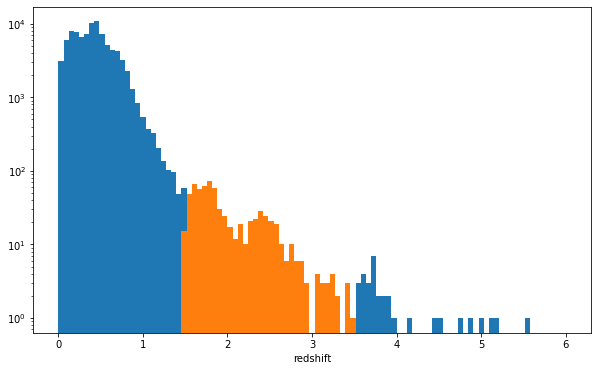

In [14]:
plt.hist(Vmax['redshift'], bins=np.linspace(0,6,100));
plt.hist(Vmax[(Vmax['redshift'] >= 1.5) & (Vmax['redshift'] <= 3.5)]['redshift'], bins=np.linspace(0,6,100));
plt.yscale('log')
plt.xlabel('redshift')

plt.show()


In [15]:
# Define sample to use
#######################
Mass = 'cigale_mstar'
redshift = 'redshift'
SFR = 'cigale_sfr'

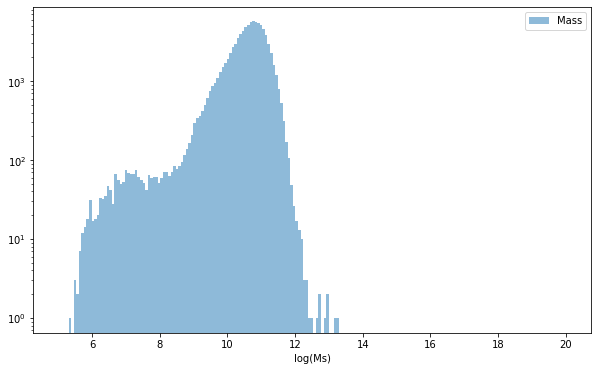

In [16]:
plt.hist(np.log10(Vmax[Mass]), bins=np.linspace(5,20,200), alpha=0.5, log=True, label='Mass');
plt.legend();
plt.xlabel('log(Ms)');

In [17]:
zmin = 1
zmax = 3
zind = (Vmax['redshift']>=zmin) & (Vmax['redshift'] <= zmax)

print('Total sample: ', len(mysample[zind]))
print('logM >= 11Ms: ',len(mysample[(zind) & (np.log10(mysample['cigale_mstar'])>=11)]))

Total sample:  2238
logM >= 11Ms:  608


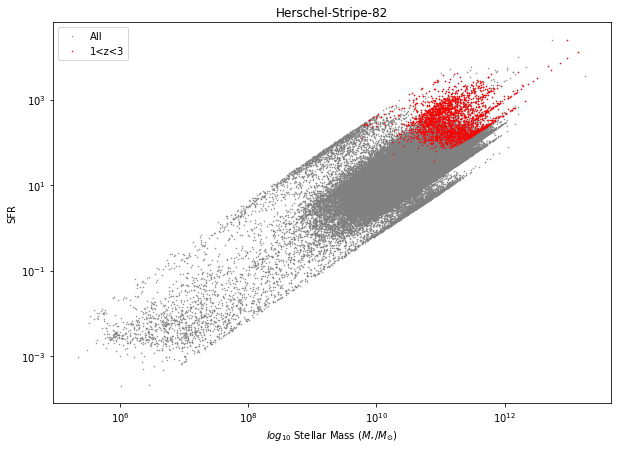

In [18]:
plt.figure(figsize=(10,7))
plt.plot(Vmax[Mass], Vmax[SFR], '.', markersize= 1, color='grey', label='All');
plt.plot(Vmax[zind][Mass], Vmax[zind][SFR], '.', markersize= 1, color='red', label='1<z<3');

plt.xlabel(r'$log_{10}$ Stellar Mass $(M_{\star} / M_{\odot})$')
plt.ylabel('SFR')

plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.title(FIELD)
# plt.savefig('./data/figs/Mscale_Alist_' + FIELD + '.png', format='png')

plt.show()

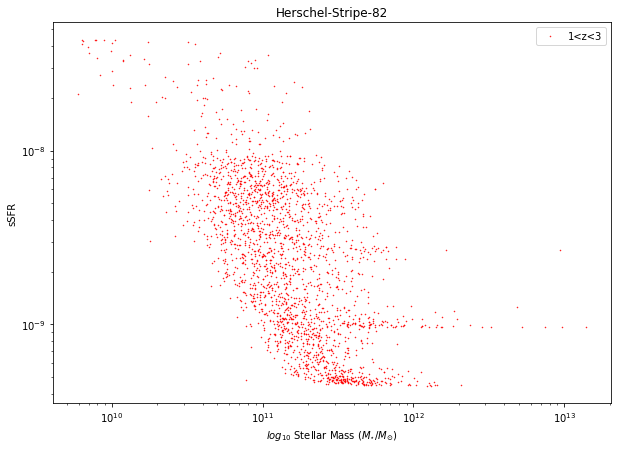

In [19]:
plt.figure(figsize=(10,7))
plt.plot(Vmax[zind][Mass], Vmax[zind][SFR]/Vmax[zind][Mass], '.', markersize= 1, color='red', label='1<z<3');

plt.xlabel(r'$log_{10}$ Stellar Mass $(M_{\star} / M_{\odot})$')
plt.ylabel('sSFR')

plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.title(FIELD)
# plt.savefig('./data/figs/Mscale_Alist_' + FIELD + '.png', format='png')

plt.show()

## 2. Vmax

Functions to use

In [20]:
def get_areas(mocs, row):
    """
    This function gets the area in which an object is observed, 
    based on whether it has been detected or not at a particular band/survey.
    
    param.
    ---------------
    mocs: dict of MOC()
        dictionary including MOCs for each survey/band.
    row: astropy.Table.row
        It should include Boolean columns for each moc_band.
    
    output
    ---------------
    area: float 
        Area in which the source have been detected (steradian).
    """
    
    row['areas'] = MOC()
    for key in mocs.keys():
#         print('getting area from ', key)
        if row['moc_'+key] == True:
#             print('It is in')
            row['areas'] += mocs[key]
        else:
#             print('it\'s not in')
            continue
    
    area = row['areas'].area
    
    return area


def select_sample_at_z(catalogue, allbands, mocs, flims, ndet=2):
    """
    
    param.
    ---------------
    catalogue: astropy.table
        HELP catalogue 
    allbands: list [[..., str]]
        Names of bands used in the selections: [[opt_bands], [nir_bands], [mir_bands]]
    mocs: dict of MOC()
        Dictionary including MOCs for each survey/band.
    flims: dict
        Flux cuts limits for each band.
    ndet: int
        Number of detections required per group of bands (opt/nir/mid). 
        Default 2; it requires 2 detection on each to pass the selection.
    
    output
    ---------------
    nb_band: astropy.Table 
        Table with selected sources -has at least "ndet" detections above the magnitude cut.
        And the area in which each source has been observed.
    """
    
    import numpy as np
    from astropy.table import Column, Table, join
    import time
    from pymoc import MOC
    
    nb_band = {}
    nb_band['help_id'] = catalogue['help_id']
    nb = ['optband', 'nirband', 'mirband']
    nx = ['optvalue', 'nirvalue', 'mirvalue']
    
    catalogue.add_column(Column(data=np.full(len(catalogue), np.empty(1)), dtype='object', 
                       name='areas'))

    r_filter = np.zeros(len(catalogue))
    names_= []
    for idx, bands in enumerate(allbands):
        nb_band[nb[idx]] = np.zeros(len(catalogue))
        nb_filter = np.zeros(len(catalogue))

        for i, filt in enumerate(bands):
            mocs_filt = [[k,f] for k,f in flims.items() if filt in k]
            ind = np.zeros(len(catalogue))
#             print('filter: ', filt)
            for key, val in mocs_filt :
#                 print('k: ', key)
#                 print('val: ', val)
                names_.append('moc_'+key)
                catalogue['moc_'+key] = catalogue['f_'+filt] >= val 
                ind_filter = 1 * (catalogue['f_'+filt] >= val)
                ind += ind_filter
            # As we can have two detections in the same filter in different surveys, e.g.: DECaLS_g and DECam_g    
            ind = 1 * (ind > 0)
            nb_filter += ind  
            
            if '_r' in filt:
                r_filter += ind 

        # sources detected in at least two filters of those bands (opt, nir, mir)
        if idx==2:
            n = 2
        else:
            n = 1
        # add flag: 1 * opt ; 2 * nir ; 4 * mir    
        nb_band[nb[idx]] += (idx+n) * (nb_filter >= ndet) 
    
    nb_band = Table(nb_band)
    # at least 1det in r band
    has_r_det = 1 * (r_filter >= 1)
    nb_band['optband'] = nb_band['optband'] * has_r_det
        
    total = np.zeros(len(catalogue))
    for i in range(len(allbands)):
        total += nb_band[nb[i]]

    nb_band['ndet_total'] = total
    for name in names_:
        nb_band[name] = catalogue[name]
        
    # add areas
    selected = nb_band['ndet_total'] == 3
    nb_band['areas'] = np.zeros(len(catalogue))
    t = time.time()
    nb_band['areas'][selected]  = catalogue[selected].to_pandas().apply(lambda x: get_areas(mocs,x), axis=1)   
    print('time getting areas: ', time.time() - t)
    
    return nb_band

In [21]:
def get_fluxes_at_z(sed_cat, sed_bands, r):
    """
    This function gets the fluxes of each source at the given bands, at a particular redshift "r"
    by redshifting the sed using CIGALE.
    
    param.
    ---------------
    sed_cat: pcigale.sed
        sed of the source at the restframe.
    sed_bands: list
        name of filters to compute the flux in cigale.
    
    output
    ---------------
    cat: astropy.Table 
        Catalogue containing the fluxes of each source at the given redshift.
    """
    cat = sed_cat.copy()
    new_sed = 'sed_z'+str(r)
    cat.add_column(Column(data=np.full(len(sed_cat), np.nan), dtype='object', 
                           name=new_sed))
                          
    mod = get_module("redshifting", redshift=r)
    for i in range(len(cat)):
        sed = (cat['seds'][i]).copy()
        mod.process(sed)
        cat[new_sed][i] = sed
    
    for band in sed_bands:
        cat['f_'+band] = cat.to_pandas().apply(lambda x: x[new_sed].compute_fnu(band), axis=1)
        
    return cat

In [228]:
def Vmax_i(area, z_min, z_max, cosmo):
    """
    """
    volume = (cosmo.comoving_volume(z_max) - cosmo.comoving_volume(z_min)) * (area/ (4* np.pi))
    return volume

In [290]:
def get_Vmax(catalogue, allbands, mocs, flims, cosmo, zmin, zmax, nbins=50):
    """
    It calculates the maximum volume each source can be observed, in a given redshift bin. 
    
    param.
    ---------------
    catalogue: astropy.table
        HELP catalogue 
    allbands: list [[..., str]]
        Names of bands used in the selections: [[opt_bands], [nir_bands], [mir_bands]]
    mocs: dict of MOC()
        Dictionary including MOCs for each survey/band.
    flims: dict
        Flux cuts limits for each band.
    cosmo: astropy.cosmology
        Cosmology parameters.
    zmin: float
        Minimum redshift bin.
    zmax: float
        Maximum redshift bin.
    nbins: int
        Number of dz inside the bin. 
        
    output
    ---------------
    Vmax: astropy.Table 
        Table including the Vmax calculation for each source.
    """
    # Bin volume
    Vmax = catalogue.copy()
#     Vmax['areas'] = np.nan
    Vmax['Vmax'] = 0.
    
    # Get sed at restframe
    seds_cat = catalogue[['help_id','seds']]
    sed_bands = [b for band in allbands for b in band]
    
    # Iterate over redshifts to get Vmax
    redshifts = np.linspace(zmin, zmax, nbins)    
    for i, r in enumerate(redshifts):
        start_r = time.time()
        print('z: ', r)
        if i==0:
            zmin_ = zmin
        else:
            zmin_ = redshifts[i-1]
        
        # Redshift the sed and get the fluxes at redshift r
        start_z = time.time()
        z_fluxes = get_fluxes_at_z(seds_cat, sed_bands,r)
        end_z = time.time()
        print('time z flux: ', end_z - start_z)
        
        start_sf = time.time()
        ind_sf = select_sample_at_z(z_fluxes,allbands,flims, mocs)
        end_sf = time.time()
        print('time sf: ', end_sf - start_sf)
        
        # Select just galaxies with 2opt and 2NIR detection --> ndet_total == 3
        start_Vmax = time.time()
        ind = ind_sf['ndet_total'] == 3
        print('There are: ', ind.sum(), ' galaxies detected at z: ', r)
        
        # Calculate Vmax for the selected sources
        # dV =  dV/(dzdΩ) * dz * dΩ
        dV = cosmo.differential_comoving_volume(r) * (r - zmin_) * ((ind_sf['areas'][ind]) / (4* np.pi))
        Vmax['Vmax'][ind] = Vmax['Vmax'][ind] + dV.value
        end_Vmax = time.time()
        print('time Vmax: ', end_Vmax - start_Vmax)
        
        print('ind_sf: ', ind_sf[:5])
        print('Vmax: ', Vmax[:5])
        
    Vmax['Vmax'].unit = dV.unit * u.steradian
    
    return Vmax #,ind_sf

In [187]:
3 * np.nan

nan

In [257]:
def plot_GSMF(zmin, zmax, catalogue, mcol, zcol, area, cosmo,
             nbins=None, bin_width=None, bin_percent=None, vmax=False):
    """
    Plot the Galaxy Stellar Mass Function between "zmin"-"zmax".  
    
    param.
    ---------------
    catalogue: astropy.table
        HELP catalogue. 
    zmin: float
        Minimum redshift bin.
    zmax: float
        Maximum redshift bin.
    mcol: str
        Name of column for Mass
    zcol: str
        Name of column for redshift.
    nbins: int
        Number of Mass bins
    bin_width: float
        Mass bin width
    bin_percent: int
        Percentage of sources on each Mass bin.
        
    output
    ---------------
    gsmf_bins: astropy.Table 
        Table including the Mass_centers and dN_dM for each Mass bin.
    """

    ind = ~np.isnan(catalogue[mcol])
    mask = (catalogue[ind][zcol] >= zmin) & (catalogue[ind][zcol] <= zmax)

    redshifts = catalogue[mask][zcol]
    Mstar = catalogue[mask][mcol]
    
    Mmin = np.log10(Mstar.min())
    Mmax = np.log10(Mstar.max())
    print('Mmin: ', Mmin)
    print('Mmax: ', Mmax)
    if nbins is not None:
        limits = np.linspace(Mmin, Mmax, nbins)
        binning = 'nbins:'+str(nbins)
    
    if bin_width is not None:
        limits = np.arange(Mmin, Mmax, bin_width)
        binning = 'binwidth:'+str(bin_width)
        
    if bin_percent is not None:
        limits = [Mmin]
        binning = 'binpercent:'+str(bin_percent)
        for i in np.arange(bin_percent,100,bin_percent):
            limits.append(np.percentile(np.log10(Mstar), i))

        limits.append(Mmax)
    
    
    bins_cent = get_center(np.array(limits))
    nbins = len(bins_cent)
    
    print('Mbin centers: ', bins_cent)
    print('Mbin limits: ', limits)
           
    gsmf_bins = Table()
    gsmf_bins.add_column(Column(data=bins_cent, name='M_centers'))
    gsmf_bins.add_column(Column(np.full(len(gsmf_bins), np.nan), name='dN_dM'))
    
    for i in range(nbins):
        # Number sources per bin
        ind = (np.log10(Mstar) > limits[i]) & (np.log10(Mstar) <= limits[i+1])
        dN = ind.sum()
        print('#sources bin', str(i), ': ', ind.sum())
        if dN == 0:
            continue

        if vmax:
            print('Vmax True')
            Vmax = catalogue[mask]['Vmax'][ind]
            Vmax[Vmax==0] = np.nan
            dN_dM = np.nansum( 1 / Vmax)
#             print('dN_dM: ', dN_dM)
                  
            
        else:
            print('Vmax False')
            Vmax = Vmax_i(area,zmin,zmax,cosmo).value
#             print('Vmax: ', Vmax)

            # Weight by 1/Vmax
            dN_dM = ind.sum() / Vmax

        binwidth = limits[i+1] - limits[i]
        dN_dM = dN_dM / binwidth
        gsmf_bins['dN_dM'][i] = dN_dM 
        
        
    
    # Plot GSMF    
    plt.grid(True)
    plt.vlines(11.5,-8.5, 0., colors='grey', linestyles='dashed')
    plt.plot(gsmf_bins['M_centers'] , np.log10(gsmf_bins['dN_dM']), 'o', markersize= 3, label='help')
    plt.plot(sherman19['Mcenter'], sherman19['dN_dM'], 'x', color='red', label='sherman+19')

    plt.title('{} < z < {} $\quad$ [{}]'.format(zmin, zmax, binning))
    plt.xlabel(r'$log$ Stellar Mass $(M_{\star} / M_{\odot})$')
    plt.ylabel('log φ($Mpc^{-3}$ $dex^{-1}$)')
    plt.ylim([-9.,-2.])
    plt.xlim([10.,13.])
    plt.legend()

#     plt.savefig('./data/gsmf_{}_z{}_z{}.png'.format(FIELD, str(zmin), str(zmax)))

    return gsmf_bins

In [25]:
helpbands = [['sdss_u',
  'suprime_g',
  'decam_g',
  'sdss_g',
  'suprime_r',
  'decam_r',
  'sdss_r',
  'suprime_i',
  'decam_i',
  'sdss_i',
  'suprime_z',
  'decam_z',
  'sdss_z',
  'suprime_y',
  'decam_y'],
 ['vista_y',
  'ukidss_y',
  'vista_h',
  'ukidss_h',
  'vista_j',
  'ukidss_j',
  'vista_ks',
  'ukidss_k']]


In [26]:
magcuts_sdss = {'sdss_u': 22.8,
 'sdss_g': 23.7,
 'sdss_r': 23.5,
 'sdss_i': 22.9,
 'sdss_z': 21.5}

magcuts_hsc = {
    'suprime_g': 25.4,
    'suprime_r': 25.4, 
    'suprime_i': 25.1,
    'suprime_z': 24.2,
    'suprime_y': 23.7}

magcuts_des = {'decam_g_des': 23.3,
 'decam_r_des': 23.1,
 'decam_i_des': 22.7,
 'decam_z_des': 21.8,
 'decam_y_des': 20.6}

magcuts_decals =  {'decam_g_decals': 23.9, 'decam_r_decals': 23.5, 'decam_z_decals': 22.5}

# vhs - s/n > 3
magcuts_vhs = {'vista_y_vhs': 20.1,
 'vista_h_vhs': 19.6,
 'vista_j_vhs': 19.9,
 'vista_ks_vhs': 19.6}

# vics - s/n > 5
magcuts_vics = {'vista_j_vics': 21.0,
 'vista_ks_vics': 21.0}

magcuts_ukidss = {'ukidss_h':19.0, 'ukidss_j':19.0, 'ukidss_k':19.0, 'ukidss_y':20.2}

mcuts = magcuts_sdss.copy()

mcuts.update(magcuts_hsc)
mcuts.update(magcuts_des)
mcuts.update(magcuts_decals)
mcuts.update(magcuts_vhs)
mcuts.update(magcuts_vics)
mcuts.update(magcuts_ukidss)


# Calculate flux limits based on the magnitude limits
flims = {}
for key, value in mcuts.items():
    flims[key] = mag_to_flux(value)[0] * 1e3 # mJy

In [28]:
#Read mocs
moc_list = glob.glob('./data/mocs/*.fits')
len(moc_list)


mocs_files = {}
for key in flims.keys():
#     print(key)
    mocs_files[key] = MOC()
    file = [f for f in moc_list if key in f]
    mocs_files[key].read(file[0])

In [35]:
# Define sample to use
#######################
Mass = 'cigale_mstar'
redshift = 'redshift'
SFR = 'cigale_sfr'

# Area
areamoc = MOC()
areamoc.read('./data/mocs/Uni_hs82_moc.fits')
area_hs82 = areamoc.area
area_sqdeg_hs82 = areamoc.area_sq_deg

# Cosmology parameters
######################
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) #Planck18 #FlatLambdaCDM(H0=67.77, Om0=0.3) 

In [36]:
print('hs82 total area: ', area_sqdeg_hs82 , ' sq deg.')

hs82 total area:  351.1668337228479  sq deg.


In [138]:
# Literature GSMF
#################
sh19_zbin1 = Table.read('./data/sherman/sherman2020a/bin1_sherman2020a.csv')
sh19_zbin2 = Table.read('./data/sherman/sherman2020a/bin2_sherman2020a.csv')
sh19_zbin3 = Table.read('./data/sherman/sherman2020a/bin3_sherman2020a.csv')
sh19_zbin4 = Table.read('./data/sherman/sherman2020a/bin4_sherman2020a.csv')

In [109]:
sample_bin1 = Vmax[(Vmax['redshift'] >= 1.5) & (Vmax['redshift'] <= 2.)]
sample_bin2 = Vmax[(Vmax['redshift'] > 2.) & (Vmax['redshift'] <= 2.5)]
sample_bin3 = Vmax[(Vmax['redshift'] > 2.5) & (Vmax['redshift'] <= 3.)]
sample_bin4 = Vmax[(Vmax['redshift'] > 3.) & (Vmax['redshift'] <= 3.5)]


In [188]:
# Redshifts
bin_plot = 'bin4'

if bin_plot == 'bin1':
    zmin = 1.5 
    zmax = 2.  
    sherman19 = sh19_zbin1
    sample_bin = sample_bin1
    
if bin_plot == 'bin2':
    zmin = 2. 
    zmax = 2.5  
    sherman19 = sh19_zbin2
    sample_bin = sample_bin2
    
if bin_plot == 'bin3':
    zmin = 2.5 
    zmax = 3.  
    sherman19 = sh19_zbin3
    sample_bin = sample_bin3
    
if bin_plot == 'bin4':
    zmin = 3. 
    zmax = 3.5  
    sherman19 = sh19_zbin4
    sample_bin = sample_bin4

print('------------------------------------')
print('parameters used')
print('------------------------------------')
print('Cosmology: ', cosmo)
print('Redshift bin: ', bin_plot)
print('Redshift range: ', zmin , ' < z < ', zmax)
# print('Area: ', u.steradian.to(u.deg**2, area_used), 'sq_deg.')
print('------------------------------------')

------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshift bin:  bin4
Redshift range:  3.0  < z <  3.5
------------------------------------


In [160]:
print('There are {} sources in bin1: 1.5 < z < 2'.format(len(sample_bin1)))
print('There are {} sources in bin2: 2 < z < 2.5'.format(len(sample_bin2)))
print('There are {} sources in bin3: 2.5 < z < 3'.format(len(sample_bin3)))
print('There are {} sources in bin4: 3 < z < 3.5'.format(len(sample_bin4)))

print('There are {} total sources in 1.5 < z < 3.5'.format(len(sample_bin1) + len(sample_bin2) + len(sample_bin3)))

There are 434 sources in bin1: 1.5 < z < 2
There are 160 sources in bin2: 2 < z < 2.5
There are 74 sources in bin3: 2.5 < z < 3
There are 20 sources in bin4: 3 < z < 3.5
There are 668 total sources in 1.5 < z < 3.5


In [115]:
sample_bin4_volume_sk = get_Vmax(sample_bin,helpbands,flims, mocs_files,cosmo,zmin, zmax, nbins=20)

z:  3.0
time z flux:  0.06345582008361816
time getting areas:  5.97916316986084
time sf:  5.983428955078125
There are:  20  galaxies detected at z:  3.0
time Vmax:  0.0004744529724121094
z:  3.026315789473684
time z flux:  0.04618334770202637
time getting areas:  6.045235633850098
time sf:  6.049575567245483
There are:  20  galaxies detected at z:  3.026315789473684
time Vmax:  0.0004956722259521484
z:  3.0526315789473686
time z flux:  0.04635167121887207
time getting areas:  5.901795148849487
time sf:  5.906118392944336
There are:  20  galaxies detected at z:  3.0526315789473686
time Vmax:  0.0004649162292480469
z:  3.0789473684210527
time z flux:  0.046173810958862305
time getting areas:  5.827585458755493
time sf:  5.831889629364014
There are:  20  galaxies detected at z:  3.0789473684210527
time Vmax:  0.0004673004150390625
z:  3.1052631578947367
time z flux:  0.045682430267333984
time getting areas:  5.797993183135986
time sf:  5.802342653274536
There are:  20  galaxies detected a

In [207]:
cols = ['help_id',
 'ra',
 'dec',
 'redshift',
 'zspec',
 'cigale_mstar',
 'cigale_mstar_err',
 'cigale_sfr',
 'cigale_sfr_err',
#         'areas',
 'Vmax']
sample_bin1_volume_sk[cols].write('./data/sample_bin1_volume_dAreaXallsky.fits', overwrite=True)

(9.0, 13.0)

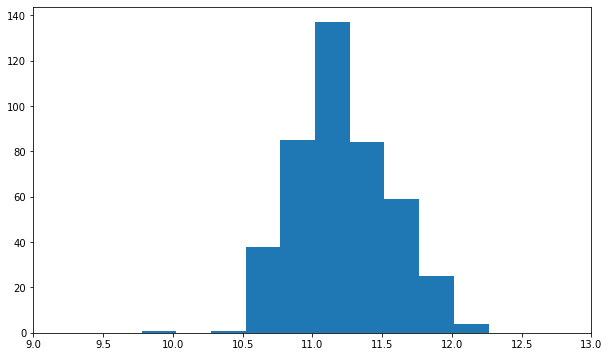

In [106]:
plt.hist(np.log10(sample_bin1_volume_sk['cigale_mstar']));
plt.xlim(9,13)

(9.0, 13.0)

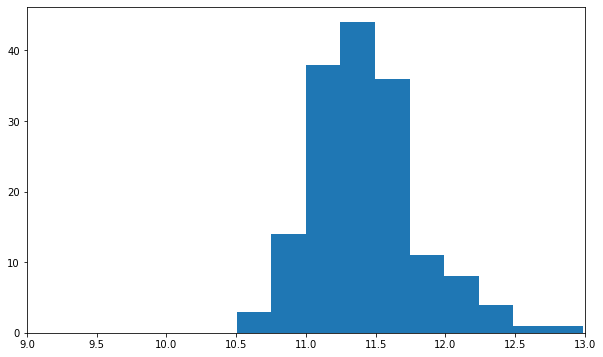

In [85]:
plt.hist(np.log10(sample_bin2_volume['cigale_mstar']));
plt.xlim(9,13)

(9.0, 13.0)

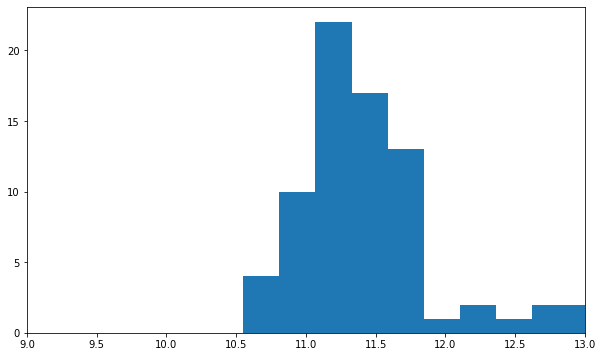

In [89]:
plt.hist(np.log10(sample_bin3_volume['cigale_mstar']));
plt.xlim(9,13)

(9.0, 13.0)

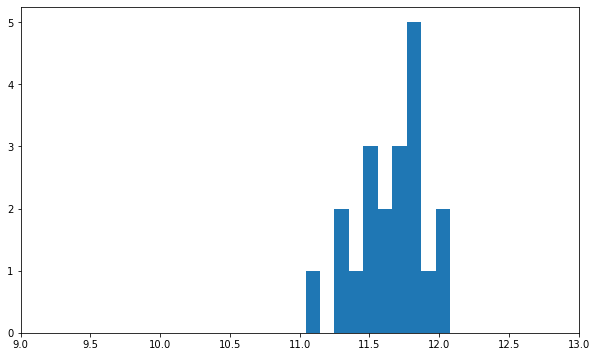

In [113]:
plt.hist(np.log10(sample_bin4_volume['cigale_mstar']));
plt.xlim(9,13)

## Plot GSMF 

- Using dArea

Mmin:  9.776023850305213
Mmax:  12.262961824819438
Mbin centers:  [ 9.91418707 10.19051351 10.46683995 10.7431664  11.01949284 11.29581928
 11.57214572 11.84847216 12.1247986 ]
Mbin limits:  [ 9.77602385 10.05235029 10.32867673 10.60500318 10.88132962 11.15765606
 11.4339825  11.71030894 11.98663538 12.26296182]
#sources bin 0 :  0
#sources bin 1 :  0
#sources bin 2 :  7
Vmax True
#sources bin 3 :  67
Vmax True
#sources bin 4 :  128
Vmax True
#sources bin 5 :  122
Vmax True
#sources bin 6 :  72
Vmax True
#sources bin 7 :  33
Vmax True
#sources bin 8 :  4
Vmax True
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


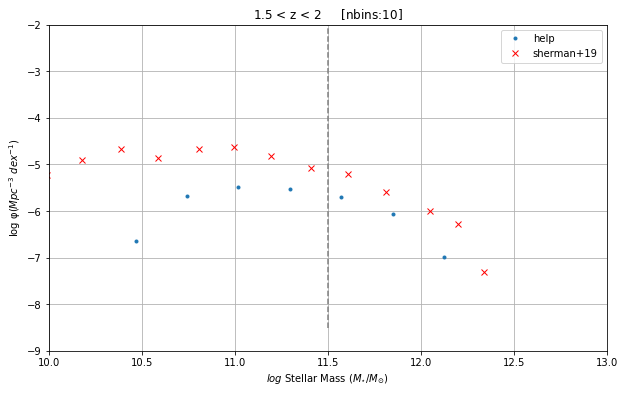

In [265]:
gsmf_b1 = plot_GSMF(1.5, 2, sample_bin1_volume_sk, Mass, redshift, area_hs82, cosmo, nbins=10, vmax=True)
print('Cosmology: ', cosmo)


Mmin:  10.502511249267933
Mmax:  12.98250233274547
Mbin centers:  [10.74276239 11.05206407 11.16839847 11.24593352 11.32176428 11.41197749
 11.51499514 11.62840943 11.76381036 12.41334167]
Mbin limits:  [10.502511249267933, 10.983013535630235, 11.121114610343572, 11.215682339096173, 11.27618469894039, 11.36734385530476, 11.456611126786251, 11.573379144189698, 11.683439713186354, 11.84418100794728, 12.98250233274547]
#sources bin 0 :  15
Vmax True
#sources bin 1 :  16
Vmax True
#sources bin 2 :  16
Vmax True
#sources bin 3 :  16
Vmax True
#sources bin 4 :  16
Vmax True
#sources bin 5 :  16
Vmax True
#sources bin 6 :  16
Vmax True
#sources bin 7 :  16
Vmax True
#sources bin 8 :  16
Vmax True
#sources bin 9 :  16
Vmax True
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


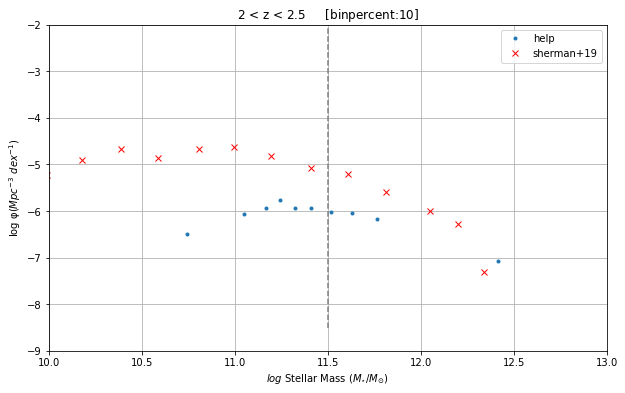

In [276]:
gsmf_b2 = plot_GSMF(2, 2.5, sample_bin2_volume_sk, Mass, redshift,area_hs82, cosmo, bin_percent=10, vmax=True)
print('Cosmology: ', cosmo)


Mmin:  10.550133725643446
Mmax:  13.141277761803643
Mbin centers:  [10.79041688 11.11849646 11.25352897 11.38708079 11.55354244 11.75123063
 12.50502532]
Mbin limits:  [10.550133725643446, 11.030700038962005, 11.206292871958857, 11.300765063551598, 11.473396508404981, 11.63368837587152, 11.868772881790402, 13.141277761803643]
#sources bin 0 :  10
Vmax True
#sources bin 1 :  11
Vmax True
#sources bin 2 :  11
Vmax True
#sources bin 3 :  11
Vmax True
#sources bin 4 :  11
Vmax True
#sources bin 5 :  11
Vmax True
#sources bin 6 :  8
Vmax True
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


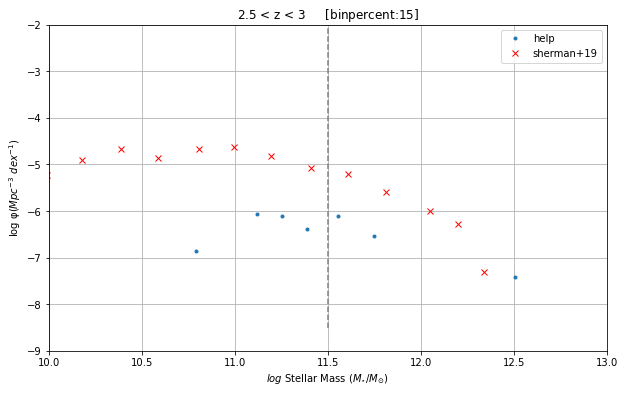

In [279]:
gsmf_b3 = plot_GSMF(2.5, 3, sample_bin3_volume_sk, Mass, redshift, area_hs82, cosmo, bin_percent=15, vmax=True)
print('Cosmology: ', cosmo)


Mmin:  10.550133725643446
Mmax:  13.141277761803643
Mbin centers:  [10.79041688 11.11849646 11.25352897 11.38708079 11.55354244 11.75123063
 12.50502532]
Mbin limits:  [10.550133725643446, 11.030700038962005, 11.206292871958857, 11.300765063551598, 11.473396508404981, 11.63368837587152, 11.868772881790402, 13.141277761803643]
#sources bin 0 :  10
Vmax True
#sources bin 1 :  11
Vmax True
#sources bin 2 :  11
Vmax True
#sources bin 3 :  11
Vmax True
#sources bin 4 :  11
Vmax True
#sources bin 5 :  11
Vmax True
#sources bin 6 :  8
Vmax True
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


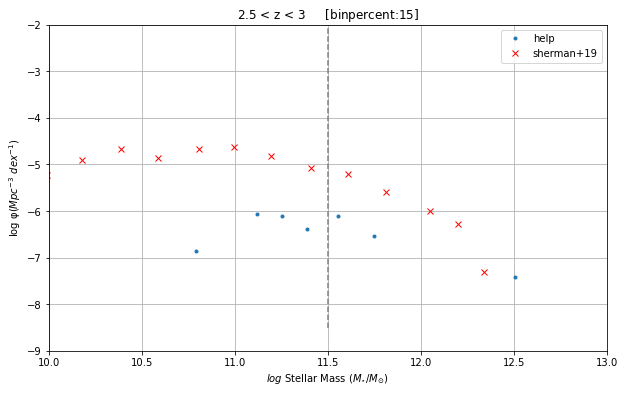

In [280]:
gsmf_b3 = plot_GSMF(2.5, 3, sample_bin3_volume_sk, Mass, redshift, area_hs82, cosmo, bin_percent=15, vmax=True)
print('Cosmology: ', cosmo)


Mmin:  11.042838240866253
Mmax:  12.078352687471911
Mbin centers:  [11.21404854 11.45641904 11.61389808 11.73342099 11.79496768 11.8734094
 12.00093058]
Mbin limits:  [11.042838240866253, 11.385258846614109, 11.527579240683755, 11.70021692339597, 11.766625046861744, 11.823310317864511, 11.923508479099867, 12.078352687471911]
#sources bin 0 :  2
Vmax True
#sources bin 1 :  3
Vmax True
#sources bin 2 :  3
Vmax True
#sources bin 3 :  3
Vmax True
#sources bin 4 :  3
Vmax True
#sources bin 5 :  3
Vmax True
#sources bin 6 :  2
Vmax True
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


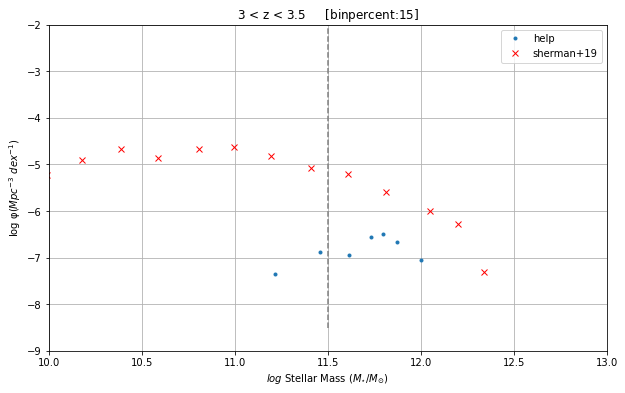

In [281]:
gsmf_b4 = plot_GSMF(3, 3.5, sample_bin4_volume_sk, Mass, redshift, area_hs82, cosmo, bin_percent=15, vmax=True)
print('Cosmology: ', cosmo)


- Using dArea * AllSky_area

Mmin:  9.776023850305213
Mmax:  12.262961824819438
Mbin centers:  [10.31544891 10.94218471 11.08816009 11.20426859 11.3481006  11.55107333
 11.96530985]
Mbin limits:  [9.776023850305213, 10.85487397244675, 11.029495443393467, 11.146824736365875, 11.26171243723821, 11.434488769418792, 11.667657882314018, 12.262961824819438]
#sources bin 0 :  64
Vmax True
#sources bin 1 :  65
Vmax True
#sources bin 2 :  65
Vmax True
#sources bin 3 :  65
Vmax True
#sources bin 4 :  65
Vmax True
#sources bin 5 :  65
Vmax True
#sources bin 6 :  44
Vmax True
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


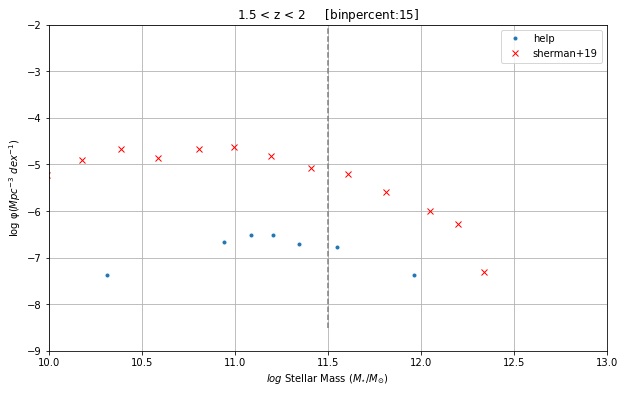

In [283]:
gsmf_b1_ = plot_GSMF(1.5, 2, sample_bin1_volume, Mass, redshift,  area_hs82, cosmo, bin_percent=15, vmax=True)
print('Cosmology: ', cosmo)


Mmin:  10.502511249267933
Mmax:  12.98250233274547
Mbin centers:  [10.77285639 11.12944193 11.26682984 11.38729424 11.5519038  11.74568874
 12.41334167]
Mbin limits:  [10.502511249267933, 11.043201528697391, 11.215682339096173, 11.317977344481196, 11.456611126786251, 11.647196480183261, 11.84418100794728, 12.98250233274547]
#sources bin 0 :  23
Vmax True
#sources bin 1 :  24
Vmax True
#sources bin 2 :  24
Vmax True
#sources bin 3 :  24
Vmax True
#sources bin 4 :  24
Vmax True
#sources bin 5 :  24
Vmax True
#sources bin 6 :  16
Vmax True
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


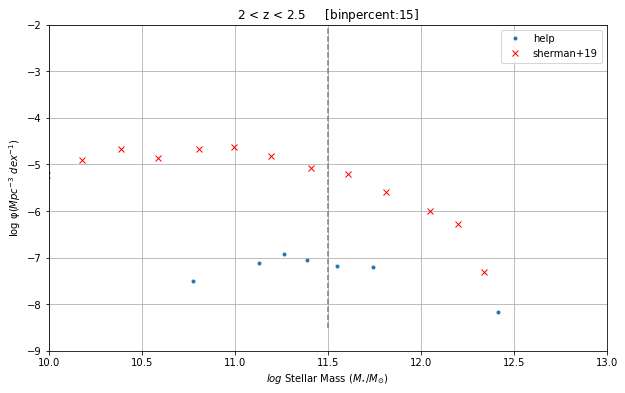

In [286]:
gsmf_b2= plot_GSMF(2, 2.5, sample_bin2_volume, Mass, redshift,  area_hs82, cosmo, bin_percent=15, vmax=True)
print('Cosmology: ', cosmo)


Mmin:  10.550133725643446
Mmax:  13.141277761803643
Mbin centers:  [10.79041688 11.11849646 11.25352897 11.38708079 11.55354244 11.75123063
 12.50502532]
Mbin limits:  [10.550133725643446, 11.030700038962005, 11.206292871958857, 11.300765063551598, 11.473396508404981, 11.63368837587152, 11.868772881790402, 13.141277761803643]
#sources bin 0 :  10
Vmax True
#sources bin 1 :  11
Vmax True
#sources bin 2 :  11
Vmax True
#sources bin 3 :  11
Vmax True
#sources bin 4 :  11
Vmax True
#sources bin 5 :  11
Vmax True
#sources bin 6 :  8
Vmax True
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


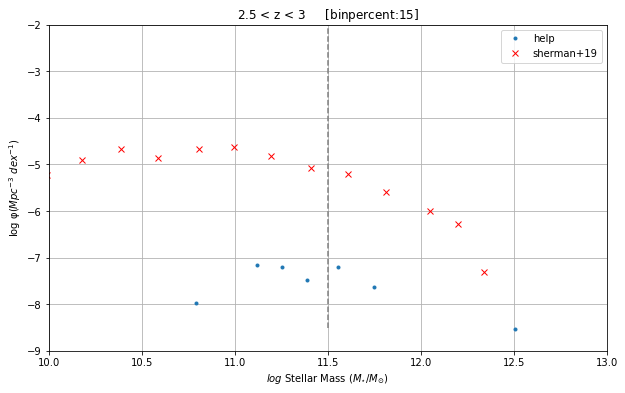

In [287]:
gsmf_b3 = plot_GSMF(2.5, 3, sample_bin3_volume, Mass, redshift,  area_hs82, cosmo, bin_percent=15, vmax=True)
print('Cosmology: ', cosmo)


Mmin:  11.042838240866253
Mmax:  12.078352687471911
Mbin centers:  [11.21404854 11.45641904 11.61389808 11.73342099 11.79496768 11.8734094
 12.00093058]
Mbin limits:  [11.042838240866253, 11.385258846614109, 11.527579240683755, 11.70021692339597, 11.766625046861744, 11.823310317864511, 11.923508479099867, 12.078352687471911]
#sources bin 0 :  2
Vmax True
#sources bin 1 :  3
Vmax True
#sources bin 2 :  3
Vmax True
#sources bin 3 :  3
Vmax True
#sources bin 4 :  3
Vmax True
#sources bin 5 :  3
Vmax True
#sources bin 6 :  2
Vmax True
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


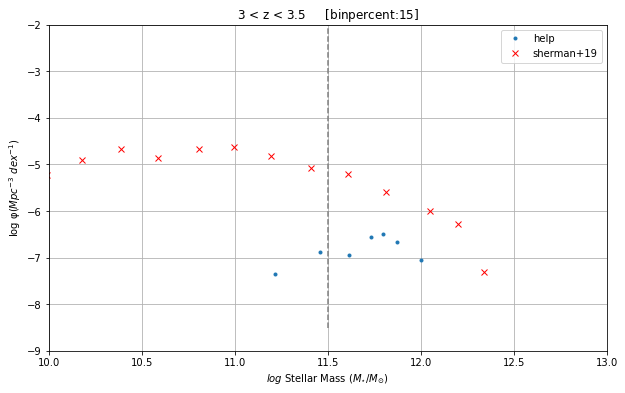

In [289]:
gsmf_b4 = plot_GSMF(3, 3.5, sample_bin4_volume_sk, Mass, redshift,  area_hs82, cosmo, bin_percent=15, vmax=True)
print('Cosmology: ', cosmo)


In [43]:
import h5py
import pandas as pd
from sphviewer.tools import QuickView
from matplotlib.colors import LogNorm
from virgodb import VirgoDB
import pyread_eagle as read_eagle

plt.rcParams["axes.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
# plt.rcParams["text.usetex"] = True
np.warnings.filterwarnings('ignore')


In [44]:
# Setup the connection
user = 'zpr066'
password = 'qgzII525'
url = 'http://galaxy-catalogue.dur.ac.uk:8080/Eagle/'
vdb = VirgoDB(user, password, url)

# Example - 0 
Taken from http://icc.dur.ac.uk/Eagle/database.php

RefL0100N1504
   mass   num
0   8.1  8940
1   8.3  6599
2   8.5  4985
3   8.7  3755
4   8.9  2786
AGNdT9L0050N0752
   mass   num
0   8.1  1203
1   8.3   843
2   8.5   611
3   8.7   475
4   8.9   370
RecalL0025N0752
   mass  num
0   8.1  105
1   8.3   88
2   8.5   60
3   8.7   39
4   8.9   43
Mmin:  10.095725735693737
Mmax:  12.683347929167248
Mbin centers:  [10.50121802 10.98991093 11.13176009 11.25345868 11.41494704 11.62356981
 12.2085511 ]
Mbin limits:  [10.095725735693737, 10.906710300210259, 11.073111568654571, 11.190408618281143, 11.316508745114772, 11.513385344035921, 11.733754269553229, 12.683347929167248]
#sources bin 0 :  58
#sources bin 1 :  59
#sources bin 2 :  58
#sources bin 3 :  59
#sources bin 4 :  58
#sources bin 5 :  59
#sources bin 6 :  39
Cosmology:  FlatLambdaCDM(H0=67.8 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


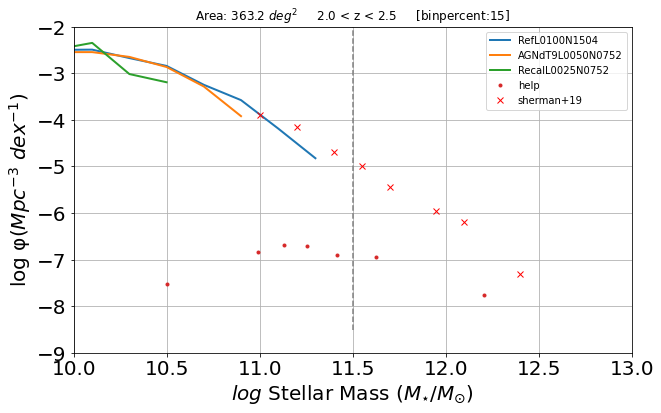

In [53]:
# Array of chosen simulations. Entries refer to the simulation name and comoving box length.
mySims= np.array([('RefL0100N1504', 100.), ('AGNdT9L0050N0752', 50.), ('RecalL0025N0752', 25.)])


for sim_name, sim_size in mySims:
    print (sim_name)
    # Construct and execute query for each simulation. This query returns the number of galaxies 
    # for a given 30 pkpc aperture stellar mass bin (centered with 0.2 dex width). 
    
    myquery = ''' SELECT        
            0.1+floor(log10(AP.Mass_Star)/0.2)*0.2 as mass,
            count(*) as num
            FROM 
            %s_SubHalo as SH,
            %s_Aperture as AP
            WHERE  
            SH.GalaxyID = AP.GalaxyID and
            AP.ApertureSize =  30 and
            AP.Mass_Star > 1e8 and       
            SH.SnapNum = 15
            GROUP BY
            0.1+floor(log10(AP.Mass_Star)/0.2)*0.2
            ORDER BY
            mass'''%(sim_name, sim_name)
            
    # Execute query.
    myData = vdb.execute_query(myquery)
    df_mydata = pd.DataFrame(myData)
    print(df_mydata[:5])

    # Normalize by volume and bin width.
    hist = myData['num'][:] / float(sim_size)**3.
    hist = hist / 0.2
    
    plt.plot(myData['mass'], np.log10(hist), label=sim_name, linewidth=2)
plot_SMF(zmin, zmax, cat, field_area, FlatLambdaCDM(H0=67.77, Om0=0.3), Mass, redshift, bin_percent=15)
print('Cosmology: ', FlatLambdaCDM(H0=67.77, Om0=0.3))

# Label plot.
#     plt.xlabel(r'log$_{10}$ M$_{*}$ [M$_{\odot}$]', fontsize=20)
#     plt.ylabel(r'log$_{10}$ dn/dlog$_{10}$(M$_{*}$) [cMpc$^{-3}$]', fontsize=20)
#     plt.tight_layout()
plt.legend()
#     plt.show()
    # plt.savefig('GSMF.png')
#     plt.close()

RefL0100N1504
   mass   num
0   8.1  7957
1   8.3  5743
2   8.5  4173
3   8.7  2995
4   8.9  2329
AGNdT9L0050N0752
   mass   num
0   8.1  1039
1   8.3   678
2   8.5   504
3   8.7   407
4   8.9   309
RecalL0025N0752
   mass  num
0   8.1   92
1   8.3   67
2   8.5   50
3   8.7   46
4   8.9   28
Mmin:  10.095725735693737
Mmax:  12.683347929167248
Mbin centers:  [10.50121802 10.98991093 11.13176009 11.25345868 11.41494704 11.62356981
 12.2085511 ]
Mbin limits:  [10.095725735693737, 10.906710300210259, 11.073111568654571, 11.190408618281143, 11.316508745114772, 11.513385344035921, 11.733754269553229, 12.683347929167248]
#sources bin 0 :  58
#sources bin 1 :  59
#sources bin 2 :  58
#sources bin 3 :  59
#sources bin 4 :  58
#sources bin 5 :  59
#sources bin 6 :  39
Cosmology:  FlatLambdaCDM(H0=67.8 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


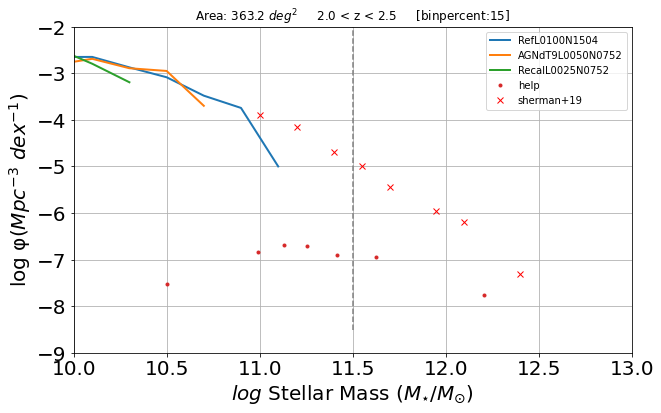

In [52]:
# Array of chosen simulations. Entries refer to the simulation name and comoving box length.
mySims= np.array([('RefL0100N1504', 100.), ('AGNdT9L0050N0752', 50.), ('RecalL0025N0752', 25.)])


for sim_name, sim_size in mySims:
    print (sim_name)
    # Construct and execute query for each simulation. This query returns the number of galaxies 
    # for a given 30 pkpc aperture stellar mass bin (centered with 0.2 dex width). 
    
    myquery = ''' SELECT        
            0.1+floor(log10(AP.Mass_Star)/0.2)*0.2 as mass,
            count(*) as num
            FROM 
            %s_SubHalo as SH,
            %s_Aperture as AP
            WHERE  
            SH.GalaxyID = AP.GalaxyID and
            AP.ApertureSize =  30 and
            AP.Mass_Star > 1e8 and       
            SH.SnapNum = 13
            GROUP BY
            0.1+floor(log10(AP.Mass_Star)/0.2)*0.2
            ORDER BY
            mass'''%(sim_name, sim_name)
            
    # Execute query.
    myData = vdb.execute_query(myquery)
    df_mydata = pd.DataFrame(myData)
    print(df_mydata[:5])

    # Normalize by volume and bin width.
    hist = myData['num'][:] / float(sim_size)**3.
    hist = hist / 0.2
    
    plt.plot(myData['mass'], np.log10(hist), label=sim_name, linewidth=2)
plot_SMF(zmin, zmax, cat, field_area, FlatLambdaCDM(H0=67.77, Om0=0.3), Mass, redshift, bin_percent=15)
print('Cosmology: ', FlatLambdaCDM(H0=67.77, Om0=0.3))

# Label plot.
#     plt.xlabel(r'log$_{10}$ M$_{*}$ [M$_{\odot}$]', fontsize=20)
#     plt.ylabel(r'log$_{10}$ dn/dlog$_{10}$(M$_{*}$) [cMpc$^{-3}$]', fontsize=20)
#     plt.tight_layout()
plt.legend()
#     plt.show()
    # plt.savefig('GSMF.png')
#     plt.close()